# Extract and load data

**Concatenate all the files to make easier the extraction**

In [169]:
#find data -type f -name "*.txt" -exec cat {} + > all_data.txt

## Extract locations and store them into a file

In [17]:
import json
import pandas as pd

with open('../data/all_data.txt', 'r', encoding='latin-1') as file:
    lines = file.readlines()

latitudes = []
longitudes = []
altitudes = []
accuracies = []

for idx, line in enumerate(lines):
    try:
        data = json.loads(line)
        if not isinstance(data, dict):
            continue
    except Exception as e:
        continue

    if 'Location' in data:
        data_location = data['Location']
        latitudes.append(data_location['Latitude'])
        longitudes.append(data_location['Longtitude'])
        altitudes.append(data_location['Altitude'])
        accuracies.append(data_location['Accuracy'])

In [18]:
df_locations = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes, "Altitude": altitudes, "Accuracy": accuracies})
# df_locations = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes, "Accuracy": accuracies})

df_locations.drop_duplicates(inplace=True)

df_locations.to_csv("../data/locations.csv", index=False)

## Load data from the .csv file

In [19]:
import pandas as pd
df_locations = pd.read_csv("../data/locations.csv")

df_locations['Altitude'] = df_locations['Altitude'].apply(lambda x: x/1000)
# df_locations['Latitude'] = df_locations['Latitude'].apply(lambda x: x*10)


In this project, we leverage a dataset derived from users' mobile phones to glean insights into global technological infrastructures. This dataset provides valuable information on mobile data usage patterns across different countries, shedding light on the diversity of technological infrastructural needs worldwide. By applying clustering algorithms to this dataset, we aim to identify regions or countries where improvements in antenna infrastructure are most crucial. These improvements will contribute to enhancing mobile signal accuracy and connectivity, thereby optimizing user experiences and supporting the advancement of mobile technology on a global scale.

# Parcial Intelligencia Artificial 2

## Clustering

To understand the data in this dataset derived from mobile phone usage, I consider several clustering techniques applicable. Specifically, I have utilized the K-means clustering technique. This technique is suitable for grouping data into a predetermined number of clusters based on similarity of features, allowing us to identify patterns and segment countries according to their mobile data usage behavior.

Furthermore, to determine the optimal number of clusters in the K-means analysis, I employed the silhouette technique. The silhouette technique calculates the cohesion and separation of clusters, helping to identify the ideal number of clusters that maximizes intra-cluster similarity and minimizes inter-cluster similarity. This provides a solid foundation for understanding the underlying data structure and extracting meaningful information about technological infrastructures in different countries.

In summary, the use of K-means in conjunction with silhouette evaluation has been instrumental in understanding the distribution and clustering needs in this dataset, enabling us to identify countries that could benefit most from improvements in antenna infrastructures to enhance the accuracy and efficiency of mobile data usage.

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm


# Define the range of cluster numbers to try
min_clusters = 10
max_clusters = 18

# Initialize variables to store the best number of clusters and the corresponding silhouette score
best_num_clusters = 0
best_silhouette_score = -1
silhouette_scores = []

df_sampled = df_locations.drop('Accuracy', axis=1).sample(50000,random_state=52)
# Iterate over the range of cluster numbers
for num_clusters in range(min_clusters, max_clusters + 1):
    # Perform clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_sampled)
    
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(df_sampled, kmeans.labels_)
    print("Silhouette score:", silhouette_avg, "with", num_clusters, "clusters")
    silhouette_scores.append(silhouette_avg)
    
    # Check if the current silhouette score is better than the previous best score
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_num_clusters = num_clusters

# Print the best number of clusters and the corresponding silhouette score
print("Best number of clusters:", best_num_clusters)
print("Silhouette score:", best_silhouette_score)


Silhouette score: 0.9010907386668401 with 10 clusters
Silhouette score: 0.9010920377518955 with 11 clusters
Silhouette score: 0.6379889920468614 with 12 clusters
Silhouette score: 0.6403440997644726 with 13 clusters
Silhouette score: 0.6405278849504589 with 14 clusters
Silhouette score: 0.6360699236832217 with 15 clusters
Silhouette score: 0.636984786755843 with 16 clusters
Silhouette score: 0.6297599005406179 with 17 clusters
Silhouette score: 0.6533006980261232 with 18 clusters
Best number of clusters: 11
Silhouette score: 0.9010920377518955


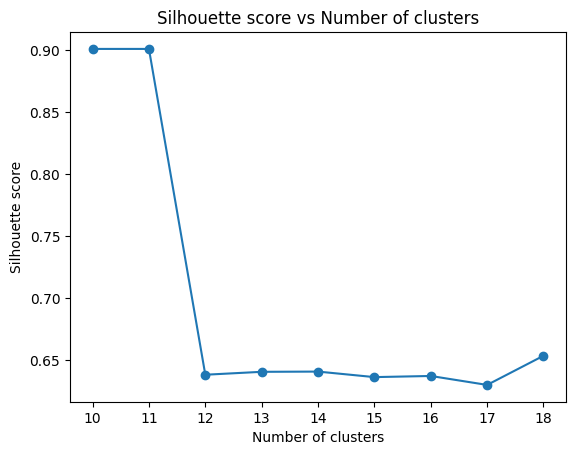

In [4]:
#plot silhoutte graph
import matplotlib.pyplot as plt

plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs Number of clusters')
plt.show()


We can see that at 11 clusters the silhoutte scored lowered a lot, and that makes us understand that the perfect number of clusters for this specific dataset is 11

In [21]:
kmeans = KMeans(n_clusters=11,random_state=42)

kmeans.fit(df_locations.drop('Accuracy', axis=1))
df_locations['Cluster'] = kmeans.predict(df_locations.drop('Accuracy', axis=1))

In [22]:
df_locations["Cluster"].value_counts()

Cluster
0     389562
1      68930
4      24483
6      14616
3      14177
10      2866
7        824
2        580
5        528
9         42
8          5
Name: count, dtype: int64

/var/folders/x5/spm_6r5944dfgx3qj8my0m440000gn/T/ipykernel_11862/2034884922.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


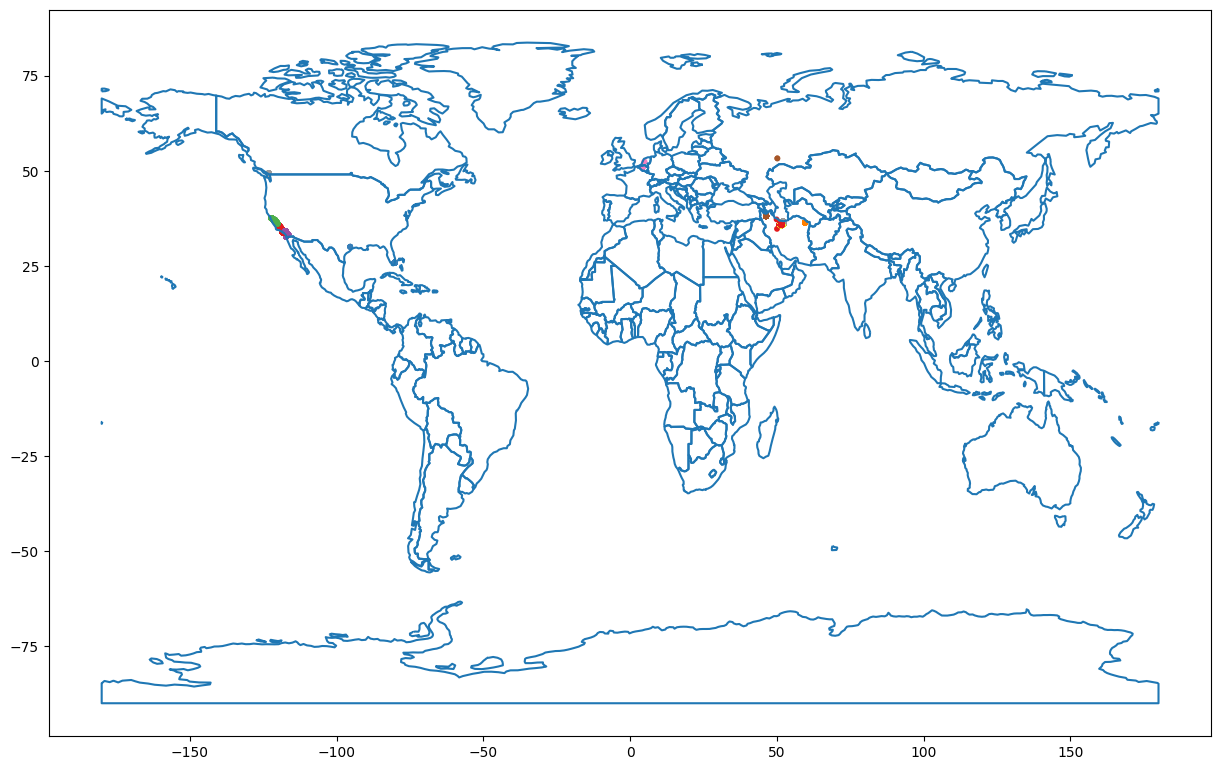

In [24]:
import geopandas as gpd
from shapely.geometry import Point

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geometry = [Point(xy) for xy in zip(df_locations['Longitude'], df_locations['Latitude'])]
gdf = gpd.GeoDataFrame(df_locations, geometry=geometry)
gdf.crs = world.crs

fig, ax = plt.subplots(figsize=(15, 15))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, column=df_locations["Cluster"], cmap='Set1', markersize=10)
plt.show()

I created a map that displays the distribution of data points from our world map dataset, utilizing distinct colors to represent different clusters identified through K-means clustering. The use of these colors effectively illustrates the correctness of our chosen number of clusters and provides insights into the geographical distribution of these clusters.

Each color on the map corresponds to a specific cluster determined by the clustering algorithm. This visualization allows us to visually discern patterns and concentrations of data points across different regions of the world. By accurately capturing the spatial distribution of these clusters, we gain a deeper understanding of the varying mobile data usage behaviors and technological infrastructure needs among different countries.

This map serves as a powerful tool for identifying regions where infrastructure improvements, such as newer antennas, may be most beneficial in enhancing mobile signal accuracy and efficiency. It reinforces the effectiveness of our clustering approach in segmenting the dataset and highlights actionable insights for optimizing mobile technology on a global scale.

## Reducción de dimensiones

To visualize the clustering results and accuracy trends based on geographical data, I utilized altitude, longitude, and latitude features. Initially, I applied Principal Component Analysis (PCA) to reduce the dimensionality from 3 to 2 dimensions. This allowed for a clearer visualization of clusters and associated accuracy metrics on a 2D graph.

In [25]:
df_locations

,Latitude,Longitude,Altitude,Accuracy,Cluster
0,35.709760,51.316011,0.0,27.000,0
1,35.709759,51.316007,0.0,25.000,0
2,35.709759,51.316007,0.0,29.000,0
3,35.709781,51.315990,0.0,25.000,0
4,35.709760,51.316007,0.0,25.000,0
...,...,...,...,...,...
516608,35.782574,51.360892,0.0,86.773,0
516609,35.782570,51.360880,0.0,86.420,0
516610,35.782560,51.360820,0.0,85.538,0
516611,35.782544,51.360890,0.0,217.383,0


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,whiten=False).fit(df_locations.drop('Accuracy', axis=1).drop('Cluster', axis=1))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
reducted = pca.fit_transform(df_locations.drop('Accuracy', axis=1).drop('Cluster', axis=1))
reductedDf = pd.DataFrame(reducted, columns=['PC1', 'PC2'])

[9.99901131e-01 8.68466712e-05]
[49615.73255786   462.39961809]


In [27]:
reductedDf['Cluster'] = df_locations['Cluster']

In [28]:
reductedDf

,PC1,PC2,Cluster
0,-35.445250,-0.043057,0
1,-35.445247,-0.043058,0
2,-35.445247,-0.043058,0
3,-35.445230,-0.043036,0
4,-35.445247,-0.043057,0
...,...,...,...
516608,-35.490664,0.029419,0
516609,-35.490651,0.029416,0
516610,-35.490592,0.029406,0
516611,-35.490661,0.029390,0


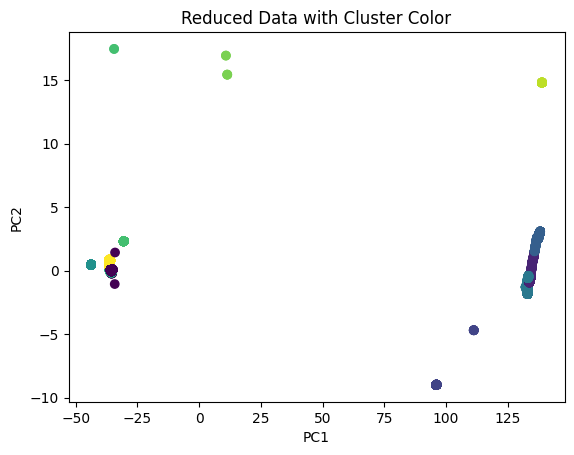

In [29]:
import matplotlib.pyplot as plt

plt.scatter(reductedDf['PC1'],reductedDf['PC2'], c=reductedDf['Cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Reduced Data with Cluster Color')
plt.show()


Here we can see the datsets clustered and in two dimension, and we can see that clusters are well definied and separated.
We have also what seems some overlapping but that is based on the altitude that is not visualized in this map

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1,whiten=False).fit(df_locations.drop('Accuracy', axis=1).drop('Cluster', axis=1))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
reducted = pca.fit_transform(df_locations.drop('Accuracy', axis=1).drop('Cluster', axis=1))
reductedDf = pd.DataFrame(reducted, columns=['PC1'])

[0.99990113]
[49615.73255786]


In [31]:
reductedDf['Cluster'] = df_locations['Cluster']

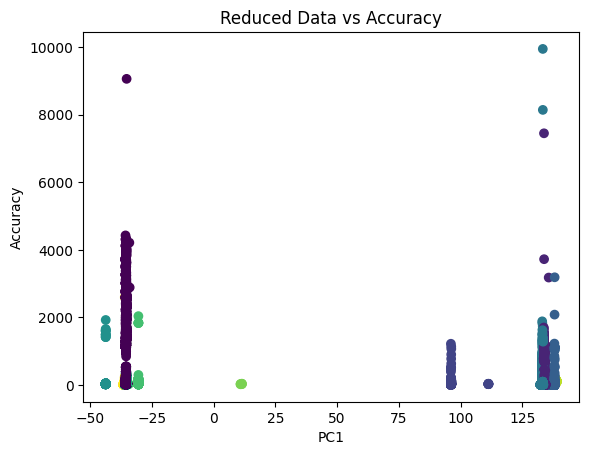

In [32]:

import matplotlib.pyplot as plt

plt.scatter(reductedDf['PC1'],df_locations['Accuracy'], c=reductedDf['Cluster'])
plt.xlabel('PC1')
plt.ylabel('Accuracy')
plt.title('Reduced Data vs Accuracy')
plt.show()


To further analyze the clustering results and accuracy trends based on geographical data, I proceeded to reduce the dimensionality from 2D to 1D using Principal Component Analysis (PCA). This transformation allowed me to condense the clustering information into a single dimension while retaining key insights about regional accuracy.

By plotting a graph with the clusters represented on the X-axis and accuracy values on the Y-axis in this 1D space, I gained a comprehensive view of how different clusters correlate with varying levels of accuracy. This visualization technique simplifies the interpretation of geographical clustering patterns and provides a clear comparison of accuracy metrics across distinct regions.

The 1D graph effectively encapsulates the essence of our clustering analysis, enabling us to identify trends and outliers in accuracy distribution among the geographical clusters. This iterative approach not only enhances the interpretability of the data but also facilitates targeted decision-making regarding infrastructure improvements based on regional performance metrics.